In [2]:
### DEFINING CONFIGS AND IMPORTING LIBRARIES ###

import torch
import numpy as np
import os
from training_setup.training_config import log, unconvert_dtypes, parse_subject_trials_from_config

# model_dir = 'andrii_brainbert_lr0.003_wd0.0_dr0.1_rR1_t20250718_164650'
model_dir = 'andrii_brainbert_lr0.003_wd0.0_dr0.1_rR2_t20250718_175158' # 10 layer BBert
subject_id = 1
session_id = 2
subject_identifier = f'mgh{subject_id}'
batch_size = 100

### LOAD CONFIG ###

# Load the checkpoint
checkpoint_path = os.path.join("runs/data", model_dir, f"model_epoch_0.pth") # Load epoch 0 just for getting the config
checkpoint = torch.load(checkpoint_path)
config = unconvert_dtypes(checkpoint['config'])
log(f"Directory name: {model_dir}", priority=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config['device'] = device
log(f"Using device: {device}", priority=0)

config['training']['train_subject_trials'] = ""
config['training']['eval_subject_trials'] = f""
parse_subject_trials_from_config(config)

config['cluster']['cache_subjects'] = False

### LOAD DATA ###
subject_id, session_id = 14, 0

log(f"Loading subjects...", priority=0)
from subject.mgh2024 import MGH2024Subject
subject = MGH2024Subject(subject_id, dtype=config['training']['data_dtype'], cache=config['cluster']['cache_subjects'], allow_corrupted=False)
all_subjects = {subject.subject_identifier: subject}

log(f"Loading the seizure dataset...", priority=0)
# WINDOW SIZE (seconds): window size that defines how much neural data to give at once
# SEIZURE REGION SIZE (seconds): for the seizure windows, how close to a "seizure" annotation does the data point have to be?
# ANNOTATION_PADDING=60*10 (seconds): for the non-seizure windows, how far every does the data point have to be from any annotation?
from evaluation.mgh2024_seizure import MGHSeizureDataset
dataset = MGHSeizureDataset(subject, session_id, WINDOW_SIZE=1, SEIZURE_REGION_SIZE=10)
log(f"Total number of samples: {len(dataset)}", indent=1)
log(f"Sample shape: {dataset[0][0].shape}, Sample label: {dataset[0][1]}", indent=1)
# Sample shape = (n_electrodes, window_size * sample_rate)

### LOAD MODEL ###

# Import the training setup class dynamically based on config
try:
    setup_module = __import__(f'training_setup.{config["training"]["setup_name"].lower()}', fromlist=[config["training"]["setup_name"]])
    setup_class = getattr(setup_module, config["training"]["setup_name"])
    training_setup = setup_class(all_subjects, config, verbose=True)
except (ImportError, AttributeError) as e:
    print(f"Could not load training setup '{config['training']['setup_name']}'. Are you sure the filename and the class name are the same and correspond to the parameter? Error: {str(e)}")
    exit()

log(f"Loading model...", priority=0)
training_setup.initialize_model()

[16:37:48 gpu 0.0G ram 0.6G] Directory name: andrii_brainbert_lr0.003_wd0.0_dr0.1_rR2_t20250718_175158
[16:37:48 gpu 0.0G ram 0.6G] Using device: cuda
[16:37:48 gpu 0.0G ram 0.6G] Loading subjects...
[16:37:49 gpu 0.0G ram 0.6G] Loading the seizure dataset...
[16:37:58 gpu 0.0G ram 0.7G]     Total number of samples: 254
[16:37:59 gpu 0.0G ram 0.7G]     Sample shape: torch.Size([162, 1024]), Sample label: 0
[16:37:59 gpu 0.0G ram 0.7G] Loading model...


In [3]:
### LOAD THE DATASET AND RUN THROUGH THE MODEL ###

# 1. Loading the data onto the GPU
batch_input = []
batch_label = []
n_skip_over_items = 1 # has to be odd so that both 1 and 0 labels are represented
for i in range(0, len(dataset), n_skip_over_items):
    batch_input.append(dataset[i][0].unsqueeze(0))
    batch_label.append(dataset[i][1])
batch_input = torch.cat(batch_input, dim=0).to(device, dtype=config['training']['data_dtype']) # shape (batch_size, n_electrodes, n_samples)
batch_label = torch.tensor(batch_label) # shape (batch_size)

original_batch = {
    'data': batch_input,
    'electrode_labels': [subject.electrode_labels],
    'metadata': {
        'subject_identifier': subject_identifier,
        'sampling_rate': subject.get_sampling_rate(session_id)
    }
}

In [10]:
log(f"Loading model weights...", priority=0)
model_epoch = 100
training_setup.load_model(model_epoch)

log(f"Loading complete!", priority=0)

[16:41:20 gpu 10.2G ram 1.3G] Loading model weights...
[16:41:20 gpu 10.2G ram 1.3G] Loading complete!


In [11]:
batch = { # make a copy of the original batch
    'data': original_batch['data'].clone(),
    'electrode_labels': original_batch['electrode_labels'],
    'metadata': original_batch['metadata']
}
for preprocess_function in training_setup.get_preprocess_functions(pretraining=False):
    batch = preprocess_function(batch)

# electrode_subset = ['LHH13', 'LAMY1', 'LHT11', 'LFId2', 'LFIb5', 'LTSb2', 'LHH10', 'LFIc9']
electrode_subset = sorted(subject.electrode_labels)
electrode_indices = [subject.electrode_labels.index(electrode) for electrode in electrode_subset]
batch['data'] = batch['data'][:, electrode_indices]
batch['electrode_labels'] = [electrode_subset]
#batch_label = batch_label.unsqueeze(1).repeat(1, len(electrode_indices))
log(f"Batch shape: {batch['data'].shape}")
log(f"Batch label shape: {batch_label.shape}")

log(f"Forwarding through the model...", priority=0)
# 2. Running the data through the model
with torch.no_grad():
    features = training_setup.generate_frozen_features(batch, stop_at_block=-2)
    features = features.mean(dim=2) # shape (batch_size, n_electrodes, d_model)

log(f"Features shape: {features.shape}") # (batch_size, n_electrodes, d_model)

[16:41:20 gpu 10.2G ram 1.3G] Batch shape: torch.Size([254, 162, 1024])
[16:41:20 gpu 10.2G ram 1.3G] Batch label shape: torch.Size([254])
[16:41:20 gpu 10.2G ram 1.3G] Forwarding through the model...
[16:41:21 gpu 10.2G ram 1.3G] Features shape: torch.Size([254, 162, 192])


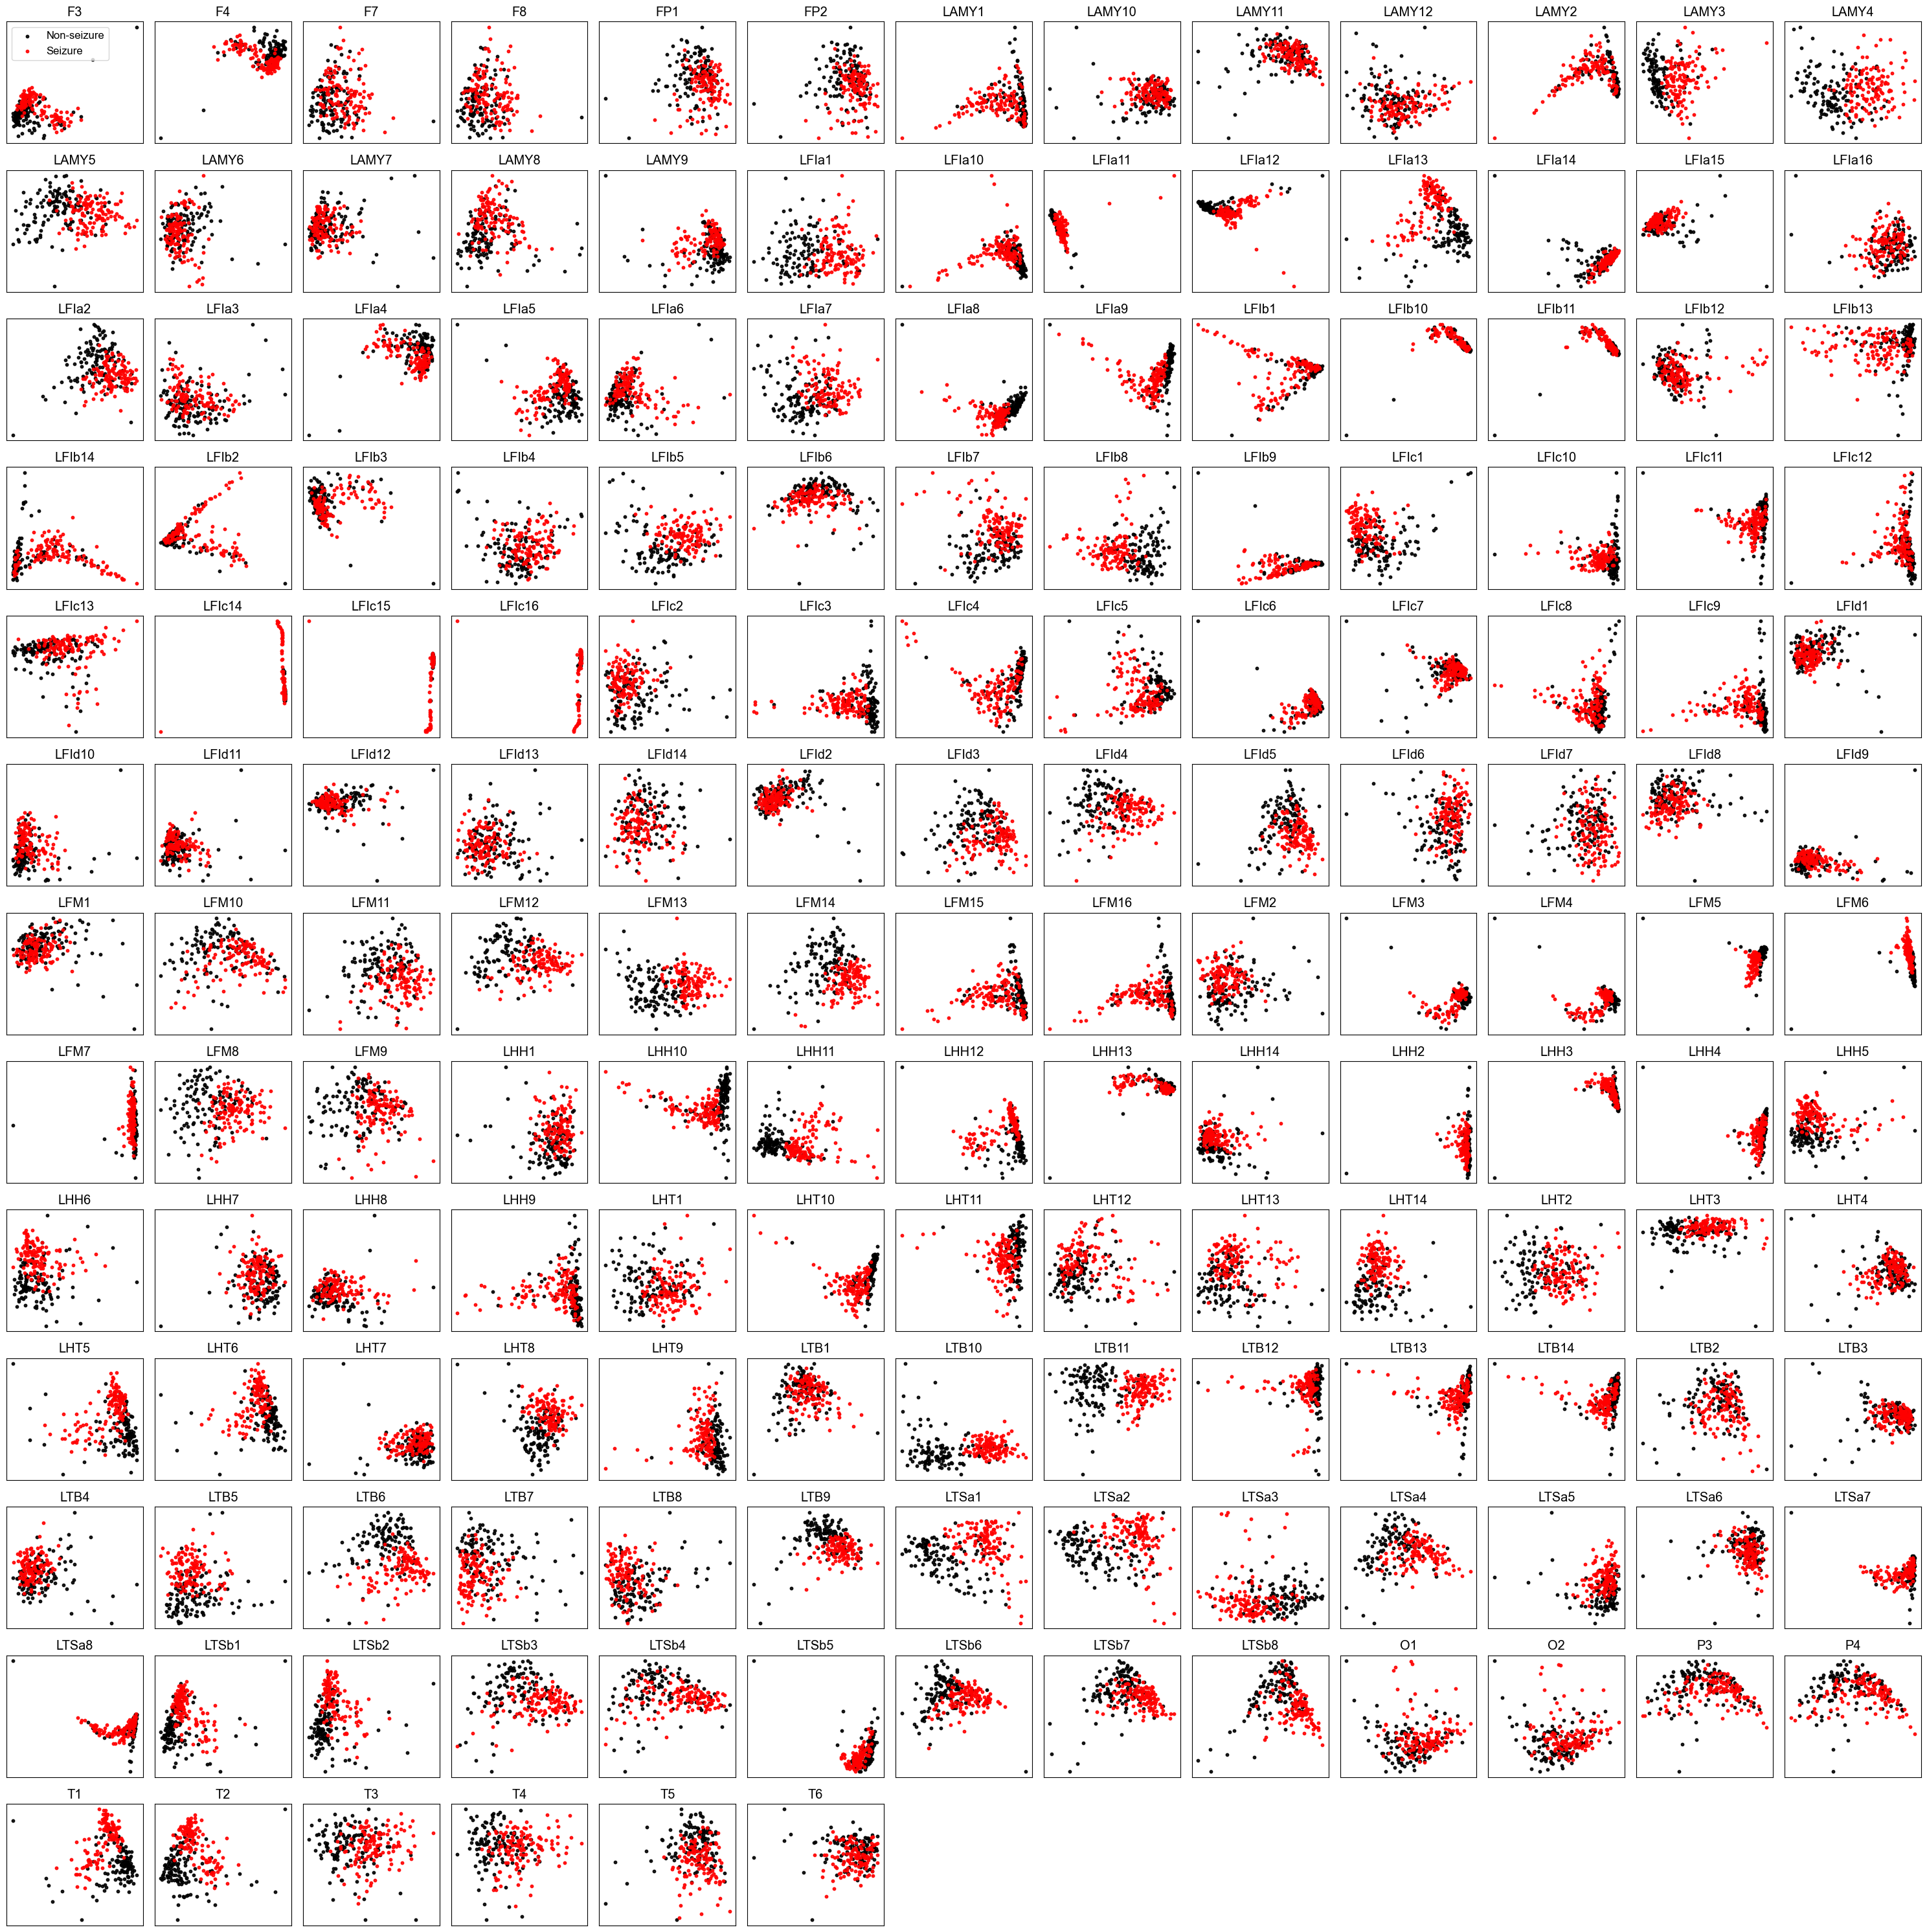

In [12]:
### PCA PLOT ###

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Calculate number of rows/cols needed for roughly square grid
n_electrodes = features.shape[1]
grid_size = int(np.ceil(np.sqrt(n_electrodes)))

# Create subplot grid
import matplotlib.font_manager as fm
fm.fontManager.addfont('analyses/font_arial.ttf')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size//4*10,grid_size//4*10))
axes = axes.flatten()

# For each electrode
for electrode_i in range(n_electrodes):
    # Get features for this electrode
    electrode_features = features[:, electrode_i, :]  # shape: (batch_size, d_model)
    electrode_labels = batch_label#[:, electrode_i]    # shape: (batch_size)
    
    # Fit and transform PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(electrode_features.cpu().float().detach().numpy())
    
    # Plot points colored by label
    for label in [0, 1]:
        mask = electrode_labels.cpu() == label
        color = 'black' if label == 0 else 'red'
        label_str = 'Seizure' if label == 1 else 'Non-seizure'
        axes[electrode_i].scatter(features_2d[mask, 0], features_2d[mask, 1],
                                c=color, label=label_str, alpha=0.9, s=10)
    
    electrode_label = subject.electrode_labels[electrode_indices[electrode_i]]
    axes[electrode_i].set_title(f'{electrode_label}')
    # axes[electrode_i].set_xlabel('PC1')
    # axes[electrode_i].set_ylabel('PC2')
    axes[electrode_i].set_xticks([])
    axes[electrode_i].set_yticks([])

    if electrode_i == 0:
        axes[electrode_i].legend()

# Hide empty subplots
for i in range(n_electrodes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig(f'analyses/andrii/25_06_brainbert/brainbert_{subject_identifier}_epoch{model_epoch}.pdf')


OLD STUFF

In [ ]:
subset_batch = {
    'data': original_batch['data'][:, electrode_indices],
    'electrode_labels': [electrode_subset]
}

features = training_setup.model.spectrogram_preprocessor(subset_batch)['data']
#features = features.reshape(features.shape[0], features.shape[1], -1)
features = features.mean(dim=2)

KeyError: 'metadata'

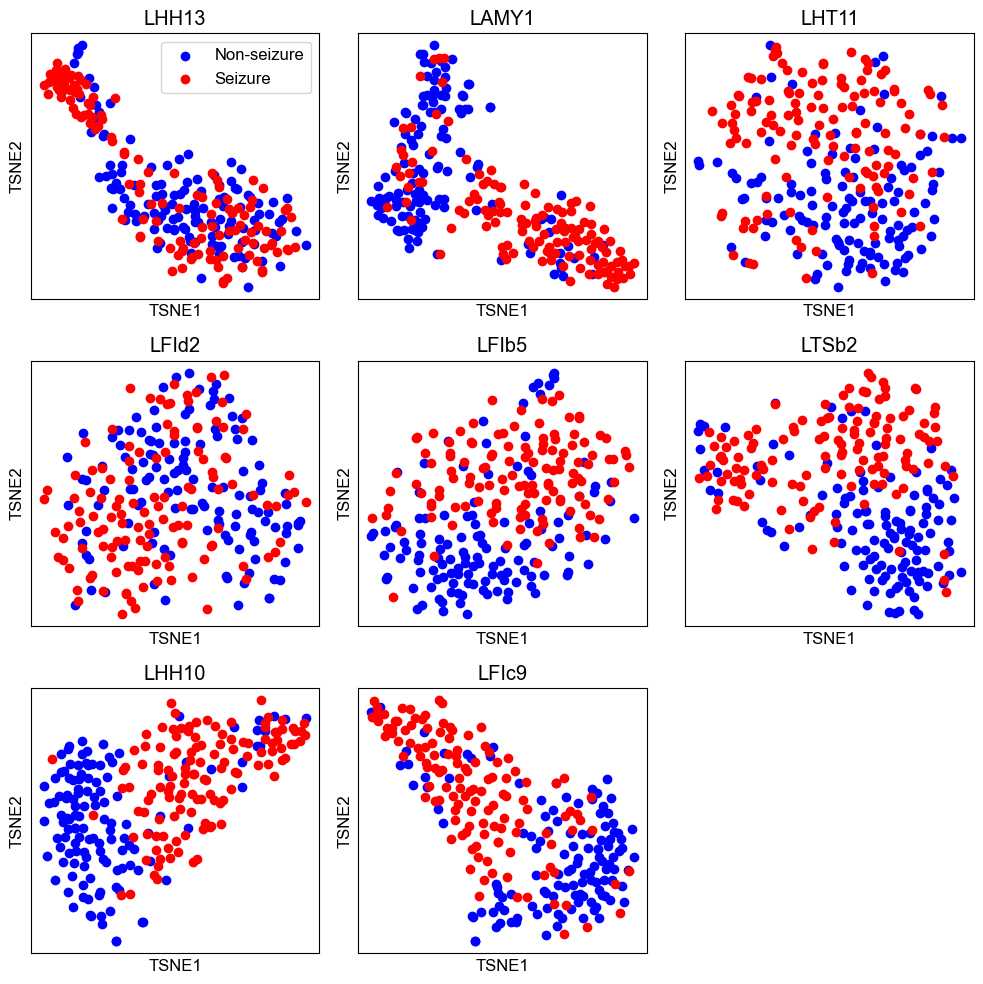

In [9]:
### TSNE PLOT ###

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Calculate number of rows/cols needed for roughly square grid
n_electrodes = features.shape[1]
grid_size = int(np.ceil(np.sqrt(n_electrodes)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10,10))
axes = axes.flatten()

# For each electrode
for electrode_i in range(n_electrodes):
    # Get features for this electrode
    electrode_features = features[:, electrode_i, :]  # shape: (batch_size, d_model)
    electrode_labels = batch_label[:, electrode_i]    # shape: (batch_size)
    
    # Fit and transform TSNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(electrode_features.cpu().detach().numpy())
    
    # Plot points colored by label
    for label in [0, 1]:
        mask = electrode_labels.cpu() == label
        color = 'blue' if label == 0 else 'red'
        label_str = 'Seizure' if label == 1 else 'Non-seizure'
        axes[electrode_i].scatter(features_2d[mask, 0], features_2d[mask, 1],
                                c=color, label=label_str)
    
    electrode_label = subject.electrode_labels[electrode_indices[electrode_i]]
    axes[electrode_i].set_title(f'{electrode_label}')
    axes[electrode_i].set_xlabel('TSNE1')
    axes[electrode_i].set_ylabel('TSNE2')
    axes[electrode_i].set_xticks([])
    axes[electrode_i].set_yticks([])

    if electrode_i == 0:
        axes[electrode_i].legend()

# Hide empty subplots
for i in range(n_electrodes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


In [10]:
### UMAP PLOT ###

from umap import UMAP
import matplotlib.pyplot as plt

# Calculate number of rows/cols needed for roughly square grid
n_electrodes = features.shape[1]
grid_size = int(np.ceil(np.sqrt(n_electrodes)))

# Create subplot grid
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10,10))
axes = axes.flatten()

# For each electrode
for electrode_i in range(n_electrodes):
    # Get features for this electrode
    electrode_features = features[:, electrode_i, :]  # shape: (batch_size, d_model)
    electrode_labels = batch_label[:, electrode_i]    # shape: (batch_size)
    
    # Fit and transform UMAP
    umap = UMAP(n_components=2, random_state=42)
    features_2d = umap.fit_transform(electrode_features.cpu().detach().numpy())
    
    # Plot points colored by label
    for label in [0, 1]:
        mask = electrode_labels.cpu() == label
        color = 'blue' if label == 0 else 'red'
        label_str = 'Seizure' if label == 1 else 'Non-seizure'
        axes[electrode_i].scatter(features_2d[mask, 0], features_2d[mask, 1],
                                c=color, label=label_str)
    
    electrode_label = subject.electrode_labels[electrode_indices[electrode_i]]
    axes[electrode_i].set_title(f'{electrode_label}')
    axes[electrode_i].set_xlabel('UMAP1')
    axes[electrode_i].set_ylabel('UMAP2')
    axes[electrode_i].set_xticks([])
    axes[electrode_i].set_yticks([])

    if electrode_i == 0:
        axes[electrode_i].legend()

# Hide empty subplots
for i in range(n_electrodes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'umap'

In [ ]:
electrode_label = "LHH10"
electrode_i = electrode_subset.index(electrode_label)

ylim_scale = 0.0002

label_0_indices = np.where(batch_label[:, electrode_i] == 0)[0]#[::5]
label_1_indices = np.where(batch_label[:, electrode_i] == 1)[0]#[::5]

batch_input_electrode = batch_input[:, electrode_i] # shape (batch_size, n_timebins)

# Plot half of the samples
n_samples = batch_input_electrode.shape[0] // 2

# Calculate number of rows needed
n_rows = max(len(label_0_indices[:n_samples]), len(label_1_indices[:n_samples]))
# Create figure with subplots - 2 columns, one for each label
fig, axes = plt.subplots(n_rows, 2, figsize=(8, 1*n_rows))
ax_left = axes[:, 0]  # Left column
ax_right = axes[:, 1] # Right column

# Plot label 0 samples in left column
for i, idx in enumerate(label_0_indices[:n_samples]):
    ax_left[i].plot(batch_input_electrode[idx].cpu().numpy(), 'b')
    #ax_left[i].set_title(f'{subject.electrode_labels[original_electrode_ids[electrode_i]]}')
    ax_left[i].set_ylim(-ylim_scale, ylim_scale)
    ax_left[i].axis('off')

# Plot label 1 samples in right column
for i, idx in enumerate(label_1_indices[:n_samples]):
    ax_right[i].plot(batch_input_electrode[idx].cpu().numpy(), 'r')
    #ax_right[i].set_title(f'{subject.electrode_labels[original_electrode_ids[electrode_i]]}')
    ax_right[i].set_ylim(-ylim_scale, ylim_scale)
    ax_right[i].axis('off')

# Hide any empty subplots
for i in range(len(label_1_indices[:n_samples]), n_rows):
    ax_right[i].set_visible(False)
for i in range(len(label_0_indices[:n_samples]), n_rows):
    ax_left[i].set_visible(False)

plt.suptitle(f'{electrode_label}\n')

plt.tight_layout()
plt.show()
